In [1]:
# discrete probability modeling

In [4]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


In [7]:
# --- Load dataset ---
df = pd.read_csv("wr_nfl_df_sorted_new_features_final.csv")

# --- Inspect the hit_value_dk target column ---
print("🔍 Value Counts:")
print(df["hit_value_dk"].value_counts(dropna=False))

print("\n🔍 Data Type:", df["hit_value_dk"].dtype)
print("❓ Missing Values:", df["hit_value_dk"].isnull().sum())

proportion = df["hit_value_dk"].mean()
print(f"\n✅ Proportion of hits (1's): {proportion:.2%}")


🔍 Value Counts:
hit_value_dk
False    11026
True      6423
Name: count, dtype: int64

🔍 Data Type: bool
❓ Missing Values: 0

✅ Proportion of hits (1's): 36.81%


In [9]:
# check potential targets
targets_to_check = [
    "hit_value_dk",
    "hit_value_fd",
    "rec_ge_7",
    "fpts_performance_bin",
    "value_ratio_dk_log_performance_bin"
]

for col in targets_to_check:
    print(f"\n📊 {col}")
    print("Value Counts:\n", df[col].value_counts(dropna=False))
    print("Data Type:", df[col].dtype)
    print("Missing Values:", df[col].isnull().sum())

    if df[col].dropna().nunique() == 2 and df[col].dtype != 'object':
        prop = df[col].mean()
        print(f"Proportion of 1's: {prop:.2%}")



📊 hit_value_dk
Value Counts:
 hit_value_dk
False    11026
True      6423
Name: count, dtype: int64
Data Type: bool
Missing Values: 0
Proportion of 1's: 36.81%

📊 hit_value_fd
Value Counts:
 hit_value_fd
False    12142
True      5307
Name: count, dtype: int64
Data Type: bool
Missing Values: 0
Proportion of 1's: 30.41%

📊 rec_ge_7
Value Counts:
 rec_ge_7
0    15642
1     1807
Name: count, dtype: int64
Data Type: int64
Missing Values: 0
Proportion of 1's: 10.36%

📊 fpts_performance_bin
Value Counts:
 fpts_performance_bin
below_avg        4211
top_performer    4186
average          4154
above_avg        4118
NaN               780
Name: count, dtype: int64
Data Type: object
Missing Values: 780

📊 value_ratio_dk_log_performance_bin
Value Counts:
 value_ratio_dk_log_performance_bin
below_avg        3710
top_performer    3667
average          3636
above_avg        3603
NaN              2833
Name: count, dtype: int64
Data Type: object
Missing Values: 2833


In [11]:
# Simulates value return tiers using a 3-tier system based on scaled value ratios.

# Parameters:
# - df: DataFrame containing 'fpts' and salary columns
# - lower: Lower threshold (float), e.g., 0.5
# - upper: Upper threshold (float), e.g., 2.0
# - platform: 'dk' or 'fd' to determine salary column

# Returns:
# - Simulated tier Series with labels: underperformed, good_return, elite_return

def simulate_value_tiers(df, lower, upper, platform="dk"):
  
    if platform not in ["dk", "fd"]:
        raise ValueError("Platform must be 'dk' or 'fd'")

    salary_col = "dk_salary" if platform == "dk" else "fd_salary"
    value_ratio_scaled = df["fpts"] / (df[salary_col] / 1000)

    # Apply 3-tier binning
    bins = [-np.inf, lower, upper, np.inf]
    labels = ["underperformed", "good_return", "elite_return"]

    simulated_tiers = pd.cut(
        value_ratio_scaled,
        bins=bins,
        labels=labels,
        include_lowest=True
    )

    # Print output
    print(f"\n📊 Tier Distribution ({platform.upper()}):")
    print(simulated_tiers.value_counts(dropna=False))

    print(f"\n📈 Tier Proportions ({platform.upper()}):")
    print(simulated_tiers.value_counts(normalize=True, dropna=False).apply(lambda x: f"{x:.2%}"))

    return simulated_tiers


In [13]:
# Define threshold boundaries
lower = 0.5
upper = 2.0

# Run DK and FD simulations using shared thresholds
simulate_value_tiers(df, lower=lower, upper=upper, platform="dk")
simulate_value_tiers(df, lower=lower, upper=upper, platform="fd")



📊 Tier Distribution (DK):
good_return       6453
underperformed    5195
elite_return      2968
NaN               2833
Name: count, dtype: int64

📈 Tier Proportions (DK):
good_return       36.98%
underperformed    29.77%
elite_return      17.01%
NaN               16.24%
Name: proportion, dtype: object

📊 Tier Distribution (FD):
good_return       6453
underperformed    6195
NaN               2833
elite_return      1968
Name: count, dtype: int64

📈 Tier Proportions (FD):
good_return       36.98%
underperformed    35.50%
NaN               16.24%
elite_return      11.28%
Name: proportion, dtype: object


0           good_return
1           good_return
2          elite_return
3           good_return
4          elite_return
              ...      
17444    underperformed
17445    underperformed
17446    underperformed
17447    underperformed
17448       good_return
Length: 17449, dtype: category
Categories (3, object): ['underperformed' < 'good_return' < 'elite_return']

In [15]:
# Define threshold boundaries
lower = 1.0
upper = 2.0

# Run DK and FD simulations using shared thresholds
simulate_value_tiers(df, lower=lower, upper=upper, platform="dk")
simulate_value_tiers(df, lower=lower, upper=upper, platform="fd")



📊 Tier Distribution (DK):
underperformed    8304
good_return       3344
elite_return      2968
NaN               2833
Name: count, dtype: int64

📈 Tier Proportions (DK):
underperformed    47.59%
good_return       19.16%
elite_return      17.01%
NaN               16.24%
Name: proportion, dtype: object

📊 Tier Distribution (FD):
underperformed    9382
good_return       3266
NaN               2833
elite_return      1968
Name: count, dtype: int64

📈 Tier Proportions (FD):
underperformed    53.77%
good_return       18.72%
NaN               16.24%
elite_return      11.28%
Name: proportion, dtype: object


0        underperformed
1        underperformed
2          elite_return
3           good_return
4          elite_return
              ...      
17444    underperformed
17445    underperformed
17446    underperformed
17447    underperformed
17448       good_return
Length: 17449, dtype: category
Categories (3, object): ['underperformed' < 'good_return' < 'elite_return']

In [17]:
### begin: logistic regression modeling ###

In [18]:
# Create  Binary Target
dk_tiers = simulate_value_tiers(df, lower=1.0, upper=2.0, platform="dk")
is_elite_return_dk = dk_tiers == "elite_return"


# Select Feature Columns
features = [
    "targets",
    "receptions",
    "rolling_fpts_diff_dk",
    "value_ratio_dk_log",
    "z_fpts_diff_dk",
    "tgt_ge_7"
]



📊 Tier Distribution (DK):
underperformed    8304
good_return       3344
elite_return      2968
NaN               2833
Name: count, dtype: int64

📈 Tier Proportions (DK):
underperformed    47.59%
good_return       19.16%
elite_return      17.01%
NaN               16.24%
Name: proportion, dtype: object


In [20]:
# subset features from df into a temporary X variable
X = df[features].copy()
y = is_elite_return_dk.copy()

In [22]:
# setup the train-test split
# train on seasons < 2023
# validation on season 2023
# final test on 2024


# Mask for seasons
mask_2024 = df["season"] == 2024
mask_2023 = df["season"] == 2023
mask_pre_2023 = df["season"] < 2023

# Full null check mask
mask_all_valid = X.notnull().all(axis=1) & y.notnull()

# Training set: Pre-2023
mask_train = mask_all_valid & mask_pre_2023
X_train = X[mask_train]
y_train = y[mask_train]

# Validation set: 2023
mask_val = mask_all_valid & mask_2023
X_val = X[mask_val]
y_val = y[mask_val]

# Final test set: 2024
mask_test = mask_all_valid & mask_2024
X_test_final = X[mask_test]
y_test_final = y[mask_test]

# Summary
print(f"Training samples:         {len(X_train)}")
print(f"Validation (2023):        {len(X_val)}")
print(f"Final Test (2024):        {len(X_test_final)}")

print("\nClass Distribution:")
print("Train:\n", y_train.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("Val:\n", y_val.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("Test:\n", y_test_final.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))


Training samples:         10699
Validation (2023):        2059
Final Test (2024):        1858

Class Distribution:
Train:
 False    79.00%
True     21.00%
Name: proportion, dtype: object
Val:
 False    80.96%
True     19.04%
Name: proportion, dtype: object
Test:
 False    82.29%
True     17.71%
Name: proportion, dtype: object


In [24]:
# Import and Initialize the Model

# Create a logistic regression model object
# Use balanced class weights to account for slight imbalance
logreg_model = LogisticRegression(
    penalty=None,               # No regularization for now (keep math pure)
    solver='lbfgs',             # Robust optimizer
    class_weight='balanced',    # Compensate for 21/79 class ratio
    max_iter=1000,              # Extra room for convergence
    random_state=42
)


In [26]:
# Fit the model on training data
logreg_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, penalty=None,
                   random_state=42)

In [28]:
# View and Interpret the Model Coefficients
# View learned coefficients with their corresponding feature names
coefficients = pd.Series(
    logreg_model.coef_[0],
    index=X_train.columns
).sort_values(ascending=False)

print("🔎 Logistic Regression Coefficients:")
print(coefficients)


🔎 Logistic Regression Coefficients:
value_ratio_dk_log      112.815383
z_fpts_diff_dk            1.651549
receptions                0.033509
targets                  -0.019074
rolling_fpts_diff_dk     -0.099089
tgt_ge_7                 -0.346638
dtype: float64


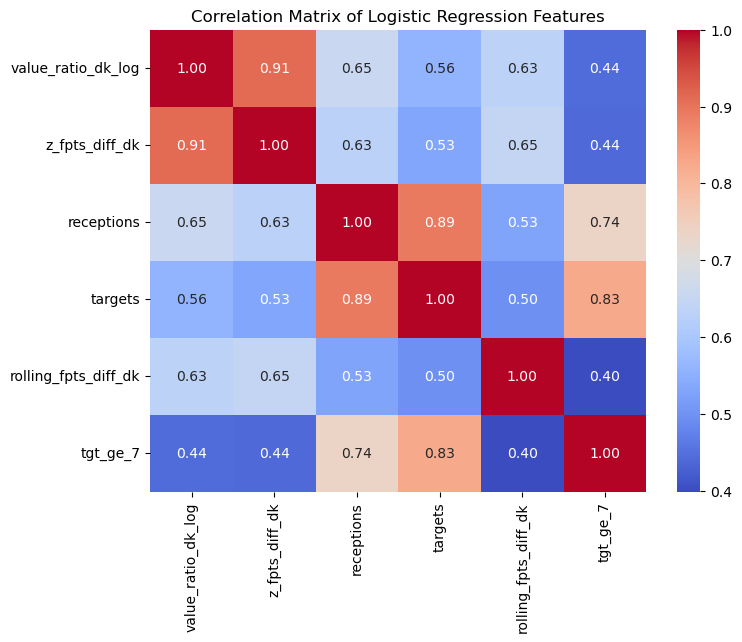

In [30]:
# Correlation Matrix Among Features
# Spot collinearity and detect proxy behavior

# Only use the features from the model
feature_cols = [
    "value_ratio_dk_log",
    "z_fpts_diff_dk",
    "receptions",
    "targets",
    "rolling_fpts_diff_dk",
    "tgt_ge_7"
]

# Compute correlation matrix (drop NaNs just in case)
corr_matrix = df[feature_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Logistic Regression Features")
plt.show()


In [32]:
# Apply regression to determine the following:
# How much z_fpts_diff_dk explains the variation in value_ratio_dk_log

# Drop rows with missing values in either variable
mask = df["value_ratio_dk_log"].notnull() & df["z_fpts_diff_dk"].notnull()
x = df.loc[mask, "z_fpts_diff_dk"]
y = df.loc[mask, "value_ratio_dk_log"]

# Add constant for intercept
x_with_const = sm.add_constant(x)

# Fit linear regression
model = sm.OLS(y, x_with_const).fit()

# View results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     value_ratio_dk_log   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                 7.184e+04
Date:                Wed, 18 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:18:05   Log-Likelihood:                 3141.2
No. Observations:               14616   AIC:                            -6278.
Df Residuals:                   14614   BIC:                            -6263.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6631      0.002    410.

In [34]:
# Drop NaNs for both features
mask = df["receptions"].notnull() & df["targets"].notnull()
x = df.loc[mask, "targets"]
y = df.loc[mask, "receptions"]

# Add constant for intercept
x_with_const = sm.add_constant(x)

# Fit linear regression model
model_targets_to_rec = sm.OLS(y, x_with_const).fit()

# Display summary
print(model_targets_to_rec.summary())


                            OLS Regression Results                            
Dep. Variable:             receptions   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 6.834e+04
Date:                Wed, 18 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:18:06   Log-Likelihood:                -26959.
No. Observations:               17449   AIC:                         5.392e+04
Df Residuals:                   17447   BIC:                         5.394e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0881      0.015     -5.928      0.0

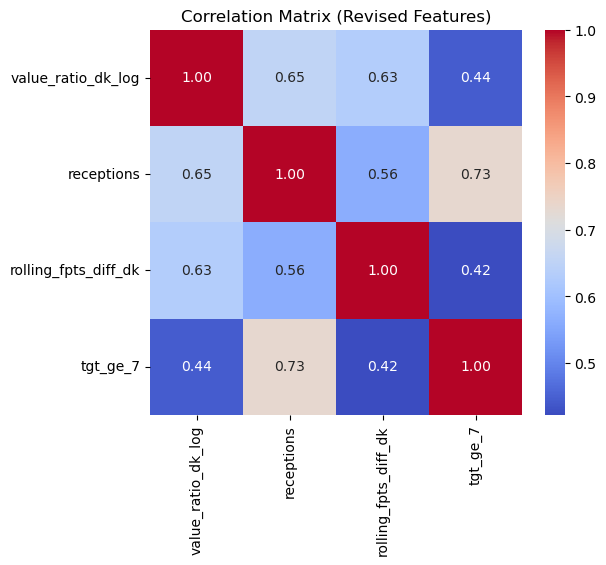

In [36]:
# Revised feature list
features_revised = [
    "value_ratio_dk_log",
    "receptions",
    "rolling_fpts_diff_dk",
    "tgt_ge_7"
]

# Compute correlation matrix (drop NaNs)
corr_matrix_revised = df[features_revised].dropna().corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix_revised, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Revised Features)")
plt.show()


In [38]:
# explore more features
candidate_features = [
    "catch_percentage",
    "catch_percentage_scaled",
    "catch_percentage_scaled_z",
    "fpts_3wk_avg",
    "avg_cushion",
    "avg_separation",
    "avg_intended_air_yards",
    "percent_share_of_intended_air_yards"
]

# Count non-null values
df[candidate_features].notnull().sum().sort_values(ascending=False)


fpts_3wk_avg                           12308
catch_percentage                        8199
catch_percentage_scaled                 8199
catch_percentage_scaled_z               8199
avg_separation                          8199
avg_intended_air_yards                  8199
percent_share_of_intended_air_yards     8199
avg_cushion                             8197
dtype: int64

In [40]:
# Revised features list
features_final = [
    "value_ratio_dk_log",
    "receptions",
    "rolling_fpts_diff_dk",
    "tgt_ge_7",
    "fpts_3wk_avg"
]


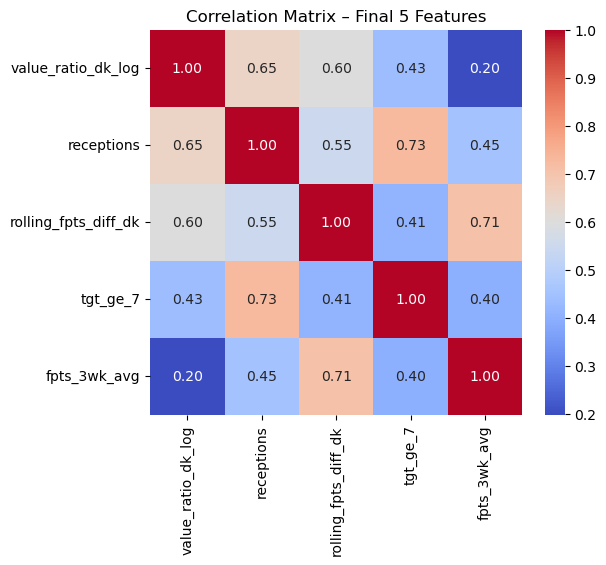

In [42]:
# Correlation check on final feature set
df[features_final].dropna().corr()

plt.figure(figsize=(6, 5))
sns.heatmap(df[features_final].dropna().corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix – Final 5 Features")
plt.show()


In [44]:
# Create Train / Validation / Test Sets
# Create season masks
mask_2024 = df["season"] == 2024
mask_2023 = df["season"] == 2023
mask_pre_2023 = df["season"] < 2023

# Create modeling mask (no missing values)
valid_mask = df[features_final].notnull().all(axis=1) & y.notnull()

# Create X and y matrices
X = df[features_final]

X_train = X[valid_mask & mask_pre_2023]
y_train = y[valid_mask & mask_pre_2023]

X_val = X[valid_mask & mask_2023]
y_val = y[valid_mask & mask_2023]

X_test = X[valid_mask & mask_2024]
y_test = y[valid_mask & mask_2024]


In [46]:
# rerun the logistic mode based on modifications to the features

# Re-initialize the logistic model (no changes needed here)
logreg_model_final = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)

# Fit model on finalized training data
logreg_model_final.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=42)

In [48]:
# This pulls from the correct model object and feature set
pd.Series(
    logreg_model_final.coef_[0],
    index=features_final
).sort_values(ascending=False)


value_ratio_dk_log      108.625975
fpts_3wk_avg             10.410099
rolling_fpts_diff_dk     -9.941595
tgt_ge_7                -22.564580
receptions             -292.720402
dtype: float64

In [57]:
# Revised model and features

# # --- Define Final Feature Sets ---
features_simplified = [
    "receptions",
    "rolling_fpts_diff_dk",
    "fpts_3wk_avg"
]

# # --- Define Final Feature Sets ---
# features_simplified = [
#     "targets",
#     "rolling_fpts_diff_dk",
#     "fpts_3wk_avg"
# ]

features_with_tgt = features_simplified + ["tgt_ge_7"]

# add targets back into the training set
X_train["targets"] = df.loc[X_train.index, "targets"]

# --- Prepare Clean Subsets (Drop Rows with Missing Values) ---
X_train_simple = X_train[features_simplified].dropna()
y_train_simple = y_train.loc[X_train_simple.index]

X_train_with_tgt = X_train[features_with_tgt].dropna()
y_train_with_tgt = y_train.loc[X_train_with_tgt.index]

# --- Initialize and Fit Logistic Models ---
logreg_simple = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)
logreg_with_tgt = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)

logreg_simple.fit(X_train_simple, y_train_simple)
logreg_with_tgt.fit(X_train_with_tgt, y_train_with_tgt)

# --- View Coefficients ---
print("🔹 Simplified Model Coefficients:")
print(pd.Series(logreg_simple.coef_[0], index=features_simplified))

print("\n🔹 With tgt_ge_7 Included:")
print(pd.Series(logreg_with_tgt.coef_[0], index=features_with_tgt))


/tmp/ipykernel_657578/1741023040.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["targets"] = df.loc[X_train.index, "targets"]


🔹 Simplified Model Coefficients:
receptions             -1644.677281
rolling_fpts_diff_dk     -69.518013
fpts_3wk_avg              62.929239
dtype: float64

🔹 With tgt_ge_7 Included:
receptions             -3082.453491
rolling_fpts_diff_dk     -12.291971
fpts_3wk_avg              19.383694
tgt_ge_7                -229.287613
dtype: float64


In [67]:
# --- Define minimum thresholds ---
min_targets = 15
min_receptions = 15

# --- Filter main dataframe before model prep ---
df_filtered = df[
    (df['targets'] >= min_targets) &
    (df['receptions'] >= min_receptions)
]

# --- Update train splits using filtered indices ---
X_train_filtered = X_train.loc[df_filtered.index.intersection(X_train.index)]
y_train_filtered = y_train.loc[X_train_filtered.index]

# --- Drop missing values for selected features ---
# features_final = ["targets", "rolling_fpts_diff_dk", "fpts_3wk_avg"]
features_receptions = ["receptions", "rolling_fpts_diff_dk", "fpts_3wk_avg"]

# --- Drop rows with NaNs in selected features ---
X_train_filtered = X_train_filtered[features_final].dropna()
y_train_filtered = y_train_filtered.loc[X_train_filtered.index]

# --- Refit model ---
logreg_filtered = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)
logreg_filtered.fit(X_train_filtered, y_train_filtered)

# --- View updated coefficients ---
print("🔍 Coefficients with Fringe Players Excluded:")
print(pd.Series(logreg_filtered.coef_[0], index=features_final))


🔍 Coefficients with Fringe Players Excluded:
value_ratio_dk_log     -6.585735
receptions             -0.823850
rolling_fpts_diff_dk   -9.489621
tgt_ge_7               -0.662604
fpts_3wk_avg            8.157076
dtype: float64


In [76]:
# --- Filter full dataframe ---
df_filtered = df[
    (df['targets'] >= 15) &
    (df['receptions'] >= 15)
].copy()

# --- Select only relevant features ---
features_receptions = ["receptions", "rolling_fpts_diff_dk", "fpts_3wk_avg"]

# --- Rebuild training input/output from scratch ---
X_train_filtered = df_filtered.loc[
    df_filtered.index.intersection(X_train.index),
    features_receptions
].dropna()

y_train_filtered = y_train.loc[X_train_filtered.index]

# --- Fit logistic regression ---
logreg_receptions = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)
logreg_receptions.fit(X_train_filtered, y_train_filtered)

# --- Output coefficients ---
print("🔍 Final Coefficients using 'receptions' only:")
print(pd.Series(logreg_receptions.coef_[0], index=features_receptions))


🔍 Final Coefficients using 'receptions' only:
receptions              -1.415037
rolling_fpts_diff_dk   -14.425400
fpts_3wk_avg            11.248845
dtype: float64


In [87]:
# *** Working Logistical Regression Model and Pipiline based on revised features *** ###

# --- Configuration ---
receptions_threshold = 1
targets_threshold = 1
features_final = ["receptions", "rolling_fpts_diff_dk", "fpts_3wk_avg"]

# --- Filter dataset for meaningful usage (per week) ---
df_filtered = df[
    (df["receptions"] >= receptions_threshold) &
    (df["targets"] >= targets_threshold)
].copy()

# --- TRAIN / VALIDATION SPLIT ---
mask_train = df_filtered["season"] < 2023
mask_val = df_filtered["season"] == 2023

X_train = df_filtered.loc[mask_train, features_final].dropna()
y_train = df_filtered.loc[X_train.index, "hit_value_dk"].astype(int)

X_val = df_filtered.loc[mask_val, features_final].dropna()
y_val = df_filtered.loc[X_val.index, "hit_value_dk"].astype(int)

# --- Fit logistic regression model ---
logreg_model = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)
logreg_model.fit(X_train, y_train)

# --- Evaluate on validation set ---
y_val_pred = logreg_model.predict(X_val)
y_val_proba = logreg_model.predict_proba(X_val)[:, 1]

# --- Print results ---
print("✅ Classification Report (2023 Validation Set):")
print(classification_report(y_val, y_val_pred, zero_division=0))

print("📊 Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("🎯 ROC AUC Score:", round(roc_auc_score(y_val, y_val_proba), 3))

print("\n📈 Logistic Regression Coefficients:")
print(pd.Series(logreg_model.coef_[0], index=features_final))


✅ Classification Report (2023 Validation Set):
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       772
           1       0.84      0.72      0.77       649

    accuracy                           0.81      1421
   macro avg       0.81      0.80      0.80      1421
weighted avg       0.81      0.81      0.81      1421

📊 Confusion Matrix:
[[681  91]
 [181 468]]
🎯 ROC AUC Score: 0.89

📈 Logistic Regression Coefficients:
receptions              0.568808
rolling_fpts_diff_dk    0.508155
fpts_3wk_avg           -0.310812
dtype: float64


In [ ]:
### end: logistic regression modeling ###